In [1]:
using Markdown#hide
cd(@__DIR__)#hide
import Pkg#hide
Pkg.activate(".")#hide

  Activating project at `C:\Users\metivier\Dropbox\PC (2)\Documents\dev\ABCConformal\example\LoktaVoltera`


# ABC-Conformal - Discrete Lokta Voltera example

Given a simulation models of Stocastic (discrete) Lokta Voltera[^model] we construct and compare three ABC methods:
- Standard ABC
- ABC-CNN: ABC method as described by [Åkesson et al. - 2021](https://ieeexplore.ieee.org/abstract/document/9525290).
- ABC-Conformal (ours): ABC method completly free of summary statistics and threshold selection as described in [Baragatti et al. - 2024](https://arxiv.org/abs/2406.04874).

The goal is to recover the three parameters of the model given an observation.

[^model]: see [D Prangle - 2017](https://projecteuclid.org/journals/bayesian-analysis/volume-12/issue-1/Adapting-the-ABC-Distance-Function/10.1214/16-BA1002.full) for an explanation of the model.

## Packages & Settings

To install and work with the same environment i.e. package version just do the following in the same folder as the `Project.toml` (and optionally also a `Manifest.toml`)
```julia
import Pkg
pkg"registry add https://github.com/dmetivie/LocalRegistry" # where I currently store `ABCConformal.jl` and `ConcreteDropoutLayer.jl` packages
Pkg.activate(".")
Pkg.instantiate()
```

In [2]:
using ABCConformal

using DataFrames, DataFramesMeta

using Random

using Distributions

using JumpProcesses # has Gillespie Methods

using Catalyst # Fancy model definition

using StatsPlots, LaTeXStrings

default(fontfamily="Computer Modern")

using MLUtils
using Lux
using LuxCUDA # comment if you use CPU
dev = gpu_device() # cpu_device()
using Lux: freeze
# using Optimisers, Zygote # only if you need more control on Optimiszer and AD
# using Accessors # to change nested structures. Useful to play with Lux.TrainState
using ConcreteDropoutLayer

## LK simulations

### Model

We simulate a stocastic Lokta Voltera model during `t_span = (0, 36)`.
We assume observations at `ts = 0:2:36`.

In [3]:
LK_model = @reaction_network begin
    α, PREY --> 2PREY
    β, PREY + PREDATOR --> 2PREDATOR
    γ, PREDATOR --> 0
end

Model ##ReactionSystem#3037
Unknowns (2):
  PREY(t)
  PREDATOR(t)
Parameters (3):
  α
  β
  γ

### Simulator

To make things challenging for an inference standpoint[^loglik], we only keep simulations with strictly positive number Prey and Predator number.

We use the Gillespie algorithm (1977) and the Julia implementation with [JumpProcesses.jl](https://docs.sciml.ai/JumpProcesses/stable/) package.
Note that compared to the `R` package [GillespieSSA2](https://github.com/rcannood/GillespieSSA2) we rougthly have a `x130` speedup with Julia.
In addition it is much more stable i.e. it handles better divergin trajectories. In our `R` version we had to use (for time constrains) the approximated `ssa_etl(tau = 1e-2)` method.
It produces a significantly different distribution of non zero trajectory (smaller variance) when compared to the `ssa_exact()` (`Direct()` in Julia) method, making the inference problem easier.


[^loglik]: In particular, any likelihood based method would be intractable.

In [4]:
condition(u, t, integrator) = u[2] == 0

affect!(integrator) = terminate!(integrator)

cb = DiscreteCallback(condition, affect!)

function output_func(sol, i)
    (θ=sol.prob.p, y=sol.u), false
end

function sample_from_θ(N, distθ::Distribution; saveat=2.0, tspan=(0.0, 36.0), u₀=[:PREY => 50, :PREDATOR => 100], jump_model=LK_model, more=1000, batch_size=ifelse(3N > 10^5, 10^5, 3N), cb=cb)
    θ = exp.(rand(distθ, more * N))
    p = (:α => 0.0, :β => 0.0, :γ => 0.0)
    n = Integer(tspan[end] ÷ saveat + 1)
    prob = DiscreteProblem(jump_model, u₀, tspan, p)
    jump_prob = JumpProblem(jump_model, prob, Direct(); save_positions=(false, false))

    prob_func = let p = p
        # https://docs.sciml.ai/DiffEqDocs/stable/features/ensemble/#Example-2:-Solving-an-SDE-with-Different-Parameters
        (jump_prob, i, repeat) -> begin
            jump_prob = remake(jump_prob, p=θ[:, i])
        end
    end

    function reduction(U, batch, I)
        nonzero_scenario = filter(u -> prod(u.y[end]) != 0, batch)
        if length(nonzero_scenario) > 0
            U[:y] = cat(U[:y], [permutedims(reduce(hcat, u.y)) for u in nonzero_scenario]...; dims=3)
            U[:θ] = hcat(U[:θ], reduce(hcat, [u.θ for u in nonzero_scenario]))
        end
        finished = size(U[:y], 3) ≥ N
        U, finished
    end

    ensemble_prob = EnsembleProblem(jump_prob, prob_func=prob_func, output_func=output_func, reduction=reduction, u_init=Dict(:θ => zeros(length(distθ), 0), :y => zeros(Int, n, length(u₀), 0)))
    sol = solve(ensemble_prob, SSAStepper(), trajectories=more * N, saveat=saveat, batch_size=batch_size, callback=cb)
    return sol.u[:θ][:, 1:N], sol.u[:y][:, :, 1:N]
end

sample_from_θ (generic function with 1 method)

# Simulation of the parameters and of the datasets

In [5]:
Random.seed!(1234)

Random.TaskLocalRNG()

## Samples

### Create training/test/validation/calibration sets

The three parameters prior is the same as in [D Prangle - 2017](https://projecteuclid.org/journals/bayesian-analysis/volume-12/issue-1/Adapting-the-ABC-Distance-Function/10.1214/16-BA1002.full).

In [6]:
dist = product_distribution([Uniform(-6, 2), Uniform(-6, 2), Uniform(-6, 2)])

dim_θ = length(dist)

dim_y = 2

nbsimus_test = 10^3

nbsimus_train = 10^5

nbsimus_cal = 10^3

@time "Sample test" θ_test, y_test = sample_from_θ(nbsimus_test, dist) # test set from prior

@time "Sample validation" θ_val, y_val = sample_from_θ(nbsimus_test, dist) # validation set

@time "Sample calibration" θ_cal, y_cal = sample_from_θ(nbsimus_cal, dist) # calibration set

@time "Sample train" θ_train, y_train = sample_from_θ(nbsimus_train, dist) # training set from prior

Sample test: 6.982049 seconds (87.09 M allocations: 6.082 GiB, 14.48% gc time, 42.84% compilation time)
Sample validation: 7.455578 seconds (81.60 M allocations: 5.707 GiB, 9.91% gc time)
Sample calibration: 8.383665 seconds (86.13 M allocations: 6.021 GiB, 9.52% gc time)
Sample train: 721.003314 seconds (8.14 G allocations: 572.376 GiB, 21.63% gc time)


([0.38919752593601226 0.3076060958601059 … 0.12570489314366037 1.0473117458432868; 0.008763807692189762 0.0031254549307253533 … 0.0027684707640392606 0.0052895699495194475; 0.5446067200547211 0.05573410752626821 … 0.537649590307325 0.6281190629466361], [50 100; 37 42; … ; 51 56; 58 46;;; 50 100; 48 131; … ; 18 66; 24 58;;; 50 100; 65 164; … ; 21 254; 4 175;;; … ;;; 50 100; 41 112; … ; 110 65; 96 93;;; 50 100; 46 37; … ; 156 39; 181 25;;; 50 100; 129 94; … ; 3 79; 16 29])

### Normalization

In [7]:
θ_train_Norm, m_θ_train, s_θ_train = my_norm(θ_train; ms=true)

θ_test_Norm, m_θ_test, s_θ_test = my_norm(θ_test; ms=true)

θ_val_Norm, m_θ_val, s_θ_val = my_norm(θ_val; ms=true)

θ_cal_Norm, m_θ_cal, s_θ_cal = my_norm(θ_cal; ms=true)

([0.5747377542647815 -0.08043973385343367 … 0.18271746753420035 0.09515299183036358; 2.7029533281856284 0.021032358939185068 … 0.8863062311265463 -0.6222999010206656; 2.49510955455922 -0.512330214650597 … 0.4486730295763999 -0.363659211659466], [0.8593137562613843; 0.00705013630067185; 0.7447362457085209;;], [1.0151457234843784; 0.006438820335729994; 0.9304552357776013;;])

### Batch

Most deep learning framework (Lux.jl, Pytorch, TensorFlow) works with Floats. In particular `Float32` are less memory consuming.

In [8]:
batch_size = 128
data_train = DataLoader((y_train .|> Float32, θ_train_Norm .|> Float32), batchsize=batch_size)
data_val = (y_val .|> Float32, θ_val_Norm .|> Float32)

(Float32[50.0 100.0; 24.0 76.0; … ; 15.0 19.0; 49.0 12.0;;; 50.0 100.0; 12.0 62.0; … ; 89.0 11.0; 82.0 108.0;;; 50.0 100.0; 45.0 72.0; … ; 89.0 84.0; 63.0 92.0;;; … ;;; 50.0 100.0; 38.0 81.0; … ; 36.0 1.0; 38.0 1.0;;; 50.0 100.0; 105.0 94.0; … ; 60.0 313.0; 24.0 113.0;;; 50.0 100.0; 15.0 118.0; … ; 2.0 76.0; 2.0 50.0], Float32[-0.19676515 -0.10425841 … 0.08464348 -0.43570384; 0.14681986 1.5585161 … -0.24449983 -0.30539808; -0.4003527 -0.009790724 … -0.19669375 -0.56094563])

## Standard ABC

In [9]:
α_ABC = 0.001 # % of sample kept

abc_method = ABC_Nearestneighbours(α_ABC, 𝕃2)

@time "ABC" results_posterior_abc = [ABC_selection(y, y_train, θ_train_Norm, abc_method) for y in eachslice(y_test, dims=3)] # the iteration depends on the format of y_test

ABC: 30.223468 seconds (100.05 M allocations: 36.514 GiB, 36.62% gc time, 0.12% compilation time)


1000-element Vector{Matrix{Float64}}:
 [-0.6021166214444731 -0.5587750909124246 … -0.6030217047494667 -0.5660276335308259; -0.521398562877827 -0.452721978542634 … -0.5178932793115043 -0.4223507899350994; -0.14459959017139606 -0.1362153186990908 … -0.12470982776730176 -0.23128619187579932]
 [-0.639930932457341 -0.6963457946627758 … -0.7060904132258214 -0.6675095425025478; -0.22152053512295122 -0.5104873834531068 … -0.54691615500164 -0.5307352463876891; -0.6302614882278896 -0.6256892580987 … -0.6537204938167464 -0.6373998934925111]
 [-0.8065814283098278 -0.8194863921402418 … -0.8175721891256691 -0.7876636644306536; -0.22555289560998876 -0.5640644519540418 … -0.5666289733669172 -0.48762947509800675; -0.6546416372530243 -0.6406728794185957 … -0.6730577085827032 -0.6406776435310813]
 [0.5420211714784773 0.9556699439050006 … 0.7978763106690921 1.0795511608359778; 0.6614460785747833 0.5622212880228907 … 1.2510754246469982 0.5652182876499662; 1.117430970417308 0.7159030672821494 … 0.6369782038

### Results

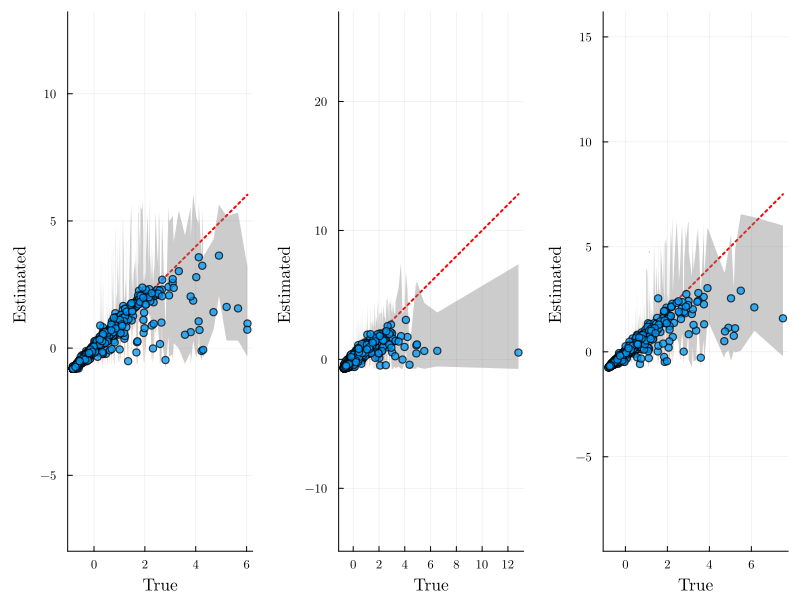

In [10]:
df_abc_result = ABC2df(results_posterior_abc, θ_test_Norm)

let
    dfs = df_abc_result
    orders = [sortperm(df.θ) for df in dfs]

    plt_abc = [@df df plot(range(extrema([:θ; :θ_hat])..., length=10), range(extrema([:θ; :θ_hat])..., length=10), xlabel="True", ylabel="Estimated ", c=:red, s=:dot, lw=2, label=:none, aspect_ratio=true) for (i, df) in enumerate(dfs)]
    [@df df plot!(plt_abc[i], :θ[orders[i]], :q_low[orders[i]], fill=(:q_high[orders[i]], 0.4, :gray), label=:none, lw=0) for (i, df) in enumerate(dfs)]
    [@df df scatter!(plt_abc[i], :θ, :θ_hat, label=:none, c=1, alpha=0.75, left_margin=4Plots.Measures.mm) for (i, df) in enumerate(dfs)]

    plot(plt_abc..., layout=(1, 3), size=(800, 600))
end

Summary metrics for the method

In [11]:
summary_abc = summary_method.(df_abc_result)

3-element Vector{DataFrame}:
 1×5 DataFrame
 Row │ NMAE      sd       IC       MedIC     Coverage 
     │ Float64   Float64  Float64  Float64   Float64  
─────┼────────────────────────────────────────────────
   1 │ 0.217997  0.47569   0.7755  0.299834     0.908
 1×5 DataFrame
 Row │ NMAE      sd        IC       MedIC    Coverage 
     │ Float64   Float64   Float64  Float64  Float64  
─────┼────────────────────────────────────────────────
   1 │ 0.350393  0.623512  1.03938  0.58471     0.974
 1×5 DataFrame
 Row │ NMAE      sd        IC        MedIC    Coverage 
     │ Float64   Float64   Float64   Float64  Float64  
─────┼─────────────────────────────────────────────────
   1 │ 0.255907  0.486053  0.765196  0.29983     0.769

## CNN as summary statistics for ABC (Akesson et al.)

Same training set. We use a validation set to select the best model version during training.

### Training

In [12]:
function build_modelCNN(dim_input, dim_out)
    model = Lux.Chain(
        Conv((2,), dim_input => 128, tanh),
        MaxPool((2,)),
        Conv((2,), 128 => 128, tanh),
        MaxPool((2,)),
        FlattenLayer(),
        Dense(512 => 128, tanh),
        Dense(128 => 128, tanh),
        Dense(128 => dim_out)
    )
    return model
end

epochs_CNN = 100

model_CNN = build_modelCNN(dim_y, dim_θ)
@time "Training ABC CNN" model_state_out_CNN, loss_train, loss_val = train_NN(model_CNN, epochs_CNN, data_train, data_val, compute_loss_mse; dev=dev)

[ Info: Epoch 1 train_loss = 0.483 validation_loss = 0.227 Best model so far
[ Info: Epoch 2 train_loss = 0.3953 validation_loss = 0.1676 Best model so far
[ Info: Epoch 3 train_loss = 0.2407 validation_loss = 0.1658 Best model so far
[ Info: Epoch 4 train_loss = 0.0368 validation_loss = 0.1431 Best model so far
[ Info: Epoch 5 train_loss = 0.0329 validation_loss = 0.1528  
[ Info: Epoch 6 train_loss = 0.0483 validation_loss = 0.1358 Best model so far
[ Info: Epoch 7 train_loss = 0.0154 validation_loss = 0.1209 Best model so far
[ Info: Epoch 8 train_loss = 0.0246 validation_loss = 0.0935 Best model so far
[ Info: Epoch 9 train_loss = 0.0613 validation_loss = 0.1314  
[ Info: Epoch 10 train_loss = 0.1719 validation_loss = 0.138  
[ Info: Epoch 11 train_loss = 0.0225 validation_loss = 0.0998  
[ Info: Epoch 12 train_loss = 0.0278 validation_loss = 0.1057  
[ Info: Epoch 13 train_loss = 0.032 validation_loss = 0.1291  
[ Info: Epoch 14 train_loss = 0.0875 validation_loss = 0.1211  
[ Inf

(Lux.Experimental.TrainState{Nothing, Nothing, Lux.Chain{@NamedTuple{layer_1::Lux.Conv{1, true, 2, typeof(NNlib.tanh_fast), typeof(WeightInitializers.glorot_uniform), typeof(WeightInitializers.zeros32)}, layer_2::Lux.MaxPool{1, 2}, layer_3::Lux.Conv{1, true, 2, typeof(NNlib.tanh_fast), typeof(WeightInitializers.glorot_uniform), typeof(WeightInitializers.zeros32)}, layer_4::Lux.MaxPool{1, 2}, layer_5::Lux.FlattenLayer{Nothing}, layer_6::Lux.Dense{true, typeof(NNlib.tanh_fast), typeof(WeightInitializers.glorot_uniform), typeof(WeightInitializers.zeros32)}, layer_7::Lux.Dense{true, typeof(NNlib.tanh_fast), typeof(WeightInitializers.glorot_uniform), typeof(WeightInitializers.zeros32)}, layer_8::Lux.Dense{true, typeof(identity), typeof(WeightInitializers.glorot_uniform), typeof(WeightInitializers.zeros32)}}, Nothing}, @NamedTuple{layer_1::@NamedTuple{weight::CUDA.CuArray{Float32, 3, CUDA.DeviceMemory}, bias::CUDA.CuArray{Float32, 3, CUDA.DeviceMemory}}, layer_2::@NamedTuple{}, layer_3::@Nam

Plot training loss

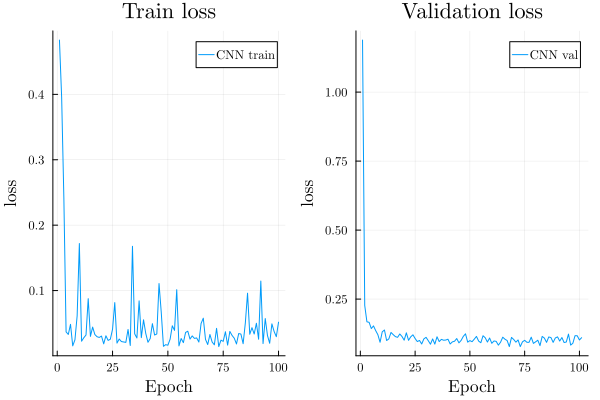

In [13]:
let
    p_train = plot(loss_train, label="CNN train", title="Train loss")
    xlabel!("Epoch")
    ylabel!("loss")
    p_test = plot(loss_val, label="CNN val", title="Validation loss")
    xlabel!("Epoch")
    ylabel!("loss")
    plot(p_train, p_test)
end

### ABC after CNN

The trainied model is used a the summary statistic function. Here we have to be careful with computation on GPU/CPU

In [14]:
η_CNN(x) = model_state_out_CNN.model(x |> dev, model_state_out_CNN.parameters, model_state_out_CNN.states) |> first |> cpu_device()

abc_method_cnn = ABC_Nearestneighbours(α_ABC, η_CNN, 𝕃2)

@time "ABC selection with η_CNN" results_posterior_cnn = ABC_selection(y_test .|> Float32, y_train .|> Float32, θ_train_Norm, abc_method_cnn)

ABC selection with η_CNN: 15.130337 seconds (100.01 M allocations: 9.332 GiB, 31.51% gc time, 0.09% compilation time)


1000-element Vector{Matrix{Float64}}:
 [-0.6645307489518002 -0.5063887817881554 … -0.6702722036338062 -0.57391008013847; -0.5994918329419077 -0.33913212656331376 … -0.32738442485241614 -0.32129613016745695; -0.2752441845444962 -0.07748820852749759 … -0.11760461183851041 -0.07712249520407734]
 [-0.5373343367360847 -0.5814389552147586 … -0.5805739909112491 -0.6543139197034044; -0.11338283072889115 -0.06425357815816207 … -0.25450850758619586 -0.3185000052844417; -0.6236134134420627 -0.6601807428457537 … -0.6035756722372062 -0.5977330866193834]
 [-0.81465191993894 -0.8147501970990836 … -0.7604232814495752 -0.7791040392233918; -0.26930351954154064 -0.40198592846708503 … -0.4214679470040694 -0.43535698419437346; -0.6670561382205956 -0.653832104429498 … -0.642663971091862 -0.6376253390448446]
 [0.9656799699342989 0.7288817340453387 … 0.701633083539748 0.7494193521727703; 0.626635150753309 0.7850824068105312 … 0.5072526987157977 0.6592059547872662; 1.2881450890856234 1.1739347920137877 … 0.766

### Results

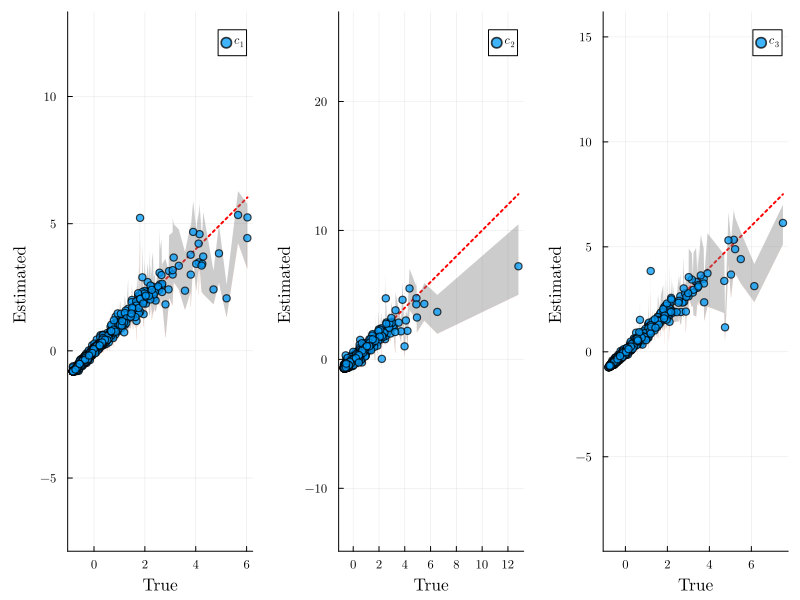

In [15]:
df_cnn_result = ABC2df(results_posterior_cnn, θ_test_Norm)

let
    dfs = df_cnn_result
    orders = [sortperm(df.θ) for df in dfs]

    plt_abc_cnn = [@df df plot(range(extrema([:θ; :θ_hat])..., length=10), range(extrema([:θ; :θ_hat])..., length=10), xlabel="True", ylabel="Estimated ", c=:red, s=:dot, lw=2, label=:none, aspect_ratio=true) for (i, df) in enumerate(dfs)]
    [@df df plot!(plt_abc_cnn[i], :θ[orders[i]], :q_low[orders[i]], fill=(:q_high[orders[i]], 0.4, :gray), label=:none, lw=0) for (i, df) in enumerate(dfs)]
    [@df df scatter!(plt_abc_cnn[i], :θ, :θ_hat, label=L"c_%$i", c=1, alpha=0.75) for (i, df) in enumerate(dfs)]
    plot(plt_abc_cnn..., layout=(1, 3), size=(800, 600), left_margin=4Plots.Measures.mm)
end

Summary metrics for the method

In [16]:
summary_abc_cnn = summary_method.(df_cnn_result)

3-element Vector{DataFrame}:
 1×5 DataFrame
 Row │ NMAE      sd        IC        MedIC     Coverage 
     │ Float64   Float64   Float64   Float64   Float64  
─────┼──────────────────────────────────────────────────
   1 │ 0.127412  0.206819  0.435059  0.282922     0.902
 1×5 DataFrame
 Row │ NMAE      sd        IC        MedIC     Coverage 
     │ Float64   Float64   Float64   Float64   Float64  
─────┼──────────────────────────────────────────────────
   1 │ 0.244533  0.294598  0.653325  0.493584     0.932
 1×5 DataFrame
 Row │ NMAE      sd        IC       MedIC     Coverage 
     │ Float64   Float64   Float64  Float64   Float64  
─────┼─────────────────────────────────────────────────
   1 │ 0.137277  0.208424  0.40937  0.243215     0.781

## ABC-Conformal

### Model with Concrete Dropout

The model is harder to train than the previous one. Using the previous model parameters one can freeze in place its parameter to only see the effect of Concrete Dropout and the heteroscedastic loss.
In this example, we don't add here regularization term for Dropout term in the loss (the parameter `λp` is a bit hard to tune).

### Training

In [17]:
function build_modelCNN_CD_freeze(dim_input, dim_output)
    Lux.Chain(
        Conv((2,), dim_input => 128, tanh) |> freeze, # Conv1D
        ConcreteDropout(; dims=(2, 3)), # ConcreteDropout1D
        MaxPool((2,)),
        Conv((2,), 128 => 128, tanh) |> freeze,
        ConcreteDropout(; dims=(2, 3)),
        MaxPool((2,)),
        FlattenLayer(),
        Dense(512 => 128, tanh) |> freeze,
        ConcreteDropout(),
        Dense(128 => 128, tanh) |> freeze,
        ConcreteDropout(),
        Parallel(nothing,
            Lux.Chain(Dense(128 => dim_output) |> freeze, ConcreteDropout()), # mean
            Lux.Chain(Dense(128 => dim_output), ConcreteDropout())  # logvar
        )
    )
end

model_CNN_CD_freeze = build_modelCNN_CD_freeze(dim_y, dim_θ)
model_state_out_CD_ini = ini_manually_CNN2CD(model_CNN_CD_freeze, model_state_out_CNN)

epochs_CD = 50
@time "Training ABC ConcreteDropout freeze" model_state_out_CD, loss_train_CD, loss_val_CD = train_NN(model_state_out_CD_ini, epochs_CD, data_train, data_val, compute_loss_heteroscedastic; dev=gpu_device())

[ Info: Epoch 1 train_loss = -0.664 validation_loss = -0.5036 Best model so far
[ Info: Epoch 2 train_loss = -1.2861 validation_loss = -1.0827 Best model so far
[ Info: Epoch 3 train_loss = -1.9224 validation_loss = -1.3233 Best model so far
[ Info: Epoch 4 train_loss = -2.2446 validation_loss = -1.9116 Best model so far
[ Info: Epoch 5 train_loss = -2.5158 validation_loss = -2.1126 Best model so far
[ Info: Epoch 6 train_loss = -2.7903 validation_loss = -1.485  
[ Info: Epoch 7 train_loss = -3.1075 validation_loss = -2.3444 Best model so far
[ Info: Epoch 8 train_loss = -3.4081 validation_loss = -2.3251  
[ Info: Epoch 9 train_loss = -3.6996 validation_loss = -2.6066 Best model so far
[ Info: Epoch 10 train_loss = -3.7362 validation_loss = -2.4542  
[ Info: Epoch 11 train_loss = -3.4616 validation_loss = -2.432  
[ Info: Epoch 12 train_loss = -3.7015 validation_loss = -2.6002  
[ Info: Epoch 13 train_loss = -3.6578 validation_loss = -2.796 Best model so far
[ Info: Epoch 14 train_loss

(Lux.Experimental.TrainState{Nothing, Nothing, Lux.Chain{@NamedTuple{layer_1::Lux.Experimental.FrozenLayer{nothing, Lux.Conv{1, true, 2, typeof(NNlib.tanh_fast), typeof(WeightInitializers.glorot_uniform), typeof(WeightInitializers.zeros32)}}, layer_2::ConcreteDropoutLayer.ConcreteDropout{Float32, Tuple{Int64, Int64}, Tuple{Float32, Float32}}, layer_3::Lux.MaxPool{1, 2}, layer_4::Lux.Experimental.FrozenLayer{nothing, Lux.Conv{1, true, 2, typeof(NNlib.tanh_fast), typeof(WeightInitializers.glorot_uniform), typeof(WeightInitializers.zeros32)}}, layer_5::ConcreteDropoutLayer.ConcreteDropout{Float32, Tuple{Int64, Int64}, Tuple{Float32, Float32}}, layer_6::Lux.MaxPool{1, 2}, layer_7::Lux.FlattenLayer{Nothing}, layer_8::Lux.Experimental.FrozenLayer{nothing, Lux.Dense{true, typeof(NNlib.tanh_fast), typeof(WeightInitializers.glorot_uniform), typeof(WeightInitializers.zeros32)}}, layer_9::ConcreteDropoutLayer.ConcreteDropout{Float32, Colon, Tuple{Float32, Float32}}, layer_10::Lux.Experimental.Fro

Compute MSE loss only (not heteroscedastic loss)

In [18]:
println("MSE CNN only ", MSELoss()(first(model_state_out_CNN.model(y_val .|> Float32 |> dev, model_state_out_CNN.parameters, model_state_out_CNN.states) |> cpu_device()), θ_val_Norm .|> Float32))
println("MSE with Concrete Dropout and heterocedastic loss ", MSELoss()(first(model_state_out_CD.model(y_val .|> Float32 |> dev, model_state_out_CD.parameters, model_state_out_CD.states) |> first |> cpu_device()), θ_val_Norm .|> Float32))

MSE CNN only 0.07780458
MSE with Concrete Dropout and heterocedastic loss 0.071063995


Print all learned Dropout rates.

In [19]:
path_cd = regularization_infos(model_state_out_CD, true)
println.(path_cd, " ", get_regularization(model_state_out_CD.parameters, path_cd));

layer_2.p_logit Float32[0.008721911]
layer_5.p_logit Float32[0.007740246]
layer_9.p_logit Float32[0.0029904551]
layer_11.p_logit Float32[4.421128f-5]
layer_12.layer_1.layer_2.p_logit Float32[0.00035364841]
layer_12.layer_2.layer_2.p_logit Float32[0.0005195042]


### MC Predict

In [20]:
@time MC_test = MC_predict(model_state_out_CD, y_test .|> Float32, 1000; dim_out=dim_θ)

  2.174169 seconds (3.16 M allocations: 2.051 GiB, 20.81% gc time)


(Float32[-0.58313555 -0.6310613 … 1.2510282 2.0190217; -0.37781212 -0.21241418 … 1.7414033 -0.328672; -0.16645241 -0.60174936 … 0.15853228 1.6132922], Float32[0.044201635 0.060039286 … 0.21931589 0.35532793; 0.12173637 0.17764819 … 0.29220703 0.38230193; 0.09060216 0.04397191 … 0.102684826 0.22062829])

Same for the calibration set

In [21]:
@time MC_cal = MC_predict(model_state_out_CD, y_cal .|> Float32, 1000, dim_out=dim_θ)

  2.247494 seconds (3.16 M allocations: 2.051 GiB, 20.25% gc time)


(Float32[0.6160979 -0.2968662 … 0.14054172 0.095219664; 2.9996574 -0.06644866 … 1.2114354 -0.591446; 2.1540265 -0.54564524 … 0.59274817 -0.2893295], Float32[0.19145353 0.11388399 … 0.07382582 0.17733026; 0.47893366 0.15788382 … 0.28646883 0.112854995; 0.29278404 0.046235505 … 0.1193184 0.11469641])

### Conformal
As an heuristic uncertainty for the conformal procedure, we use the predictive variance, which is the sum of the aleatoric and the epistemic variances.

In [22]:
α_conformal = 0.05
df_cd_test_conformal = conformilize(MC_test, MC_cal, θ_test_Norm, θ_cal_Norm, α_conformal)

3-element Vector{DataFrame}:
 1000×5 DataFrame
  Row │ θ           θ_hat       σ_tot      q_low       q_high      
      │ Float64     Float64     Float64    Float64     Float64     
──────┼────────────────────────────────────────────────────────────
    1 │ -0.601785   -0.583136   0.0442016  -0.659406   -0.506865
    2 │ -0.664514   -0.631061   0.0600393  -0.734659   -0.527463
    3 │ -0.814025   -0.810263   0.0481303  -0.893312   -0.727214
    4 │  0.677366    0.800378   0.104911    0.619353    0.981402
    5 │  6.03348     5.48305    2.25848     1.58603     9.38007
    6 │ -0.82147    -0.815037   0.0433288  -0.889801   -0.740273
    7 │  0.567396    0.642743   0.114495    0.445182    0.840304
    8 │ -0.371191   -0.274019   0.0845561  -0.41992    -0.128117
  ⋮   │     ⋮           ⋮           ⋮          ⋮            ⋮
  994 │ -0.82476    -0.795854   0.0351952  -0.856583   -0.735125
  995 │ -0.0708951  -0.0899794  0.0847404  -0.236199    0.0562404
  996 │ -0.727549   -0.746465   0.051

### Results

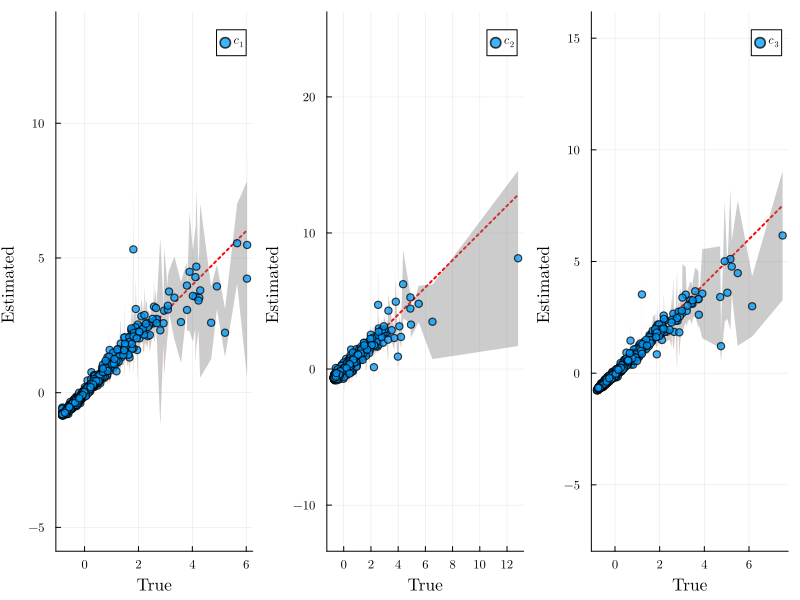

In [23]:
let
    dfs = df_cd_test_conformal
    orders = [sortperm(df.θ) for df in dfs]

    plt_abc_c = [@df df plot(range(extrema([:θ; :θ_hat])..., length=10), range(extrema([:θ; :θ_hat])..., length=10), xlabel="True", ylabel="Estimated ", c=:red, s=:dot, lw=2, label=:none, aspect_ratio=true) for (i, df) in enumerate(dfs)]
    [@df df plot!(plt_abc_c[i], :θ[orders[i]], :q_low[orders[i]], fill=(:q_high[orders[i]], 0.4, :gray), label=:none, lw=0) for (i, df) in enumerate(dfs)]
    [@df df scatter!(plt_abc_c[i], :θ, :θ_hat, label=L"c_%$i", c=1, alpha=0.75) for (i, df) in enumerate(dfs)]

    plot(plt_abc_c..., layout=(1, 3), size=(800, 600))
end

Summary metrics for the method

In [24]:
summary_abc_conformal = summary_method.(df_cd_test_conformal)

3-element Vector{DataFrame}:
 1×5 DataFrame
 Row │ NMAE      sd        IC        MedIC     Coverage 
     │ Float64   Float64   Float64   Float64   Float64  
─────┼──────────────────────────────────────────────────
   1 │ 0.129963  0.206282  0.456292  0.286745     0.948
 1×5 DataFrame
 Row │ NMAE      sd        IC        MedIC     Coverage 
     │ Float64   Float64   Float64   Float64   Float64  
─────┼──────────────────────────────────────────────────
   1 │ 0.246041  0.282764  0.680633  0.480829     0.944
 1×5 DataFrame
 Row │ NMAE      sd        IC        MedIC     Coverage 
     │ Float64   Float64   Float64   Float64   Float64  
─────┼──────────────────────────────────────────────────
   1 │ 0.133717  0.204607  0.388528  0.243058     0.861

# Comparison of all methods

In [25]:
using PrettyTables
df_results = map(1:dim_θ) do i
    vcat(summary_abc[i], summary_abc_cnn[i], summary_abc_conformal[i])
end

hl_min(col) = HtmlHighlighter(
    (data, i, j) -> (j == col) && data[i, col] == minimum(data[:, col]),
    # MarkdownDecoration(bold=true)
    HtmlDecoration(color = "blue", font_weight = "bold")
    # crayon"blue bold"
)

for i in 1:dim_θ
    pretty_table(
        hcat(["ABC", "ABC CNN", "ABC Conformal"], Matrix(df_results[i]));
        #    backend = Val(:markdown),
        backend = Val(:html),
        standalone = true,
        highlighters=(hl_min(2), hl_min(3), hl_min(4), hl_min(5)),
        # border_crayon=crayon"yellow",
        formatters=ft_printf("%5.2f", 2:4),
        #    tf            = tf_unicode_rounded,
        header=vcat("c$i  Method", names(df_results[i]))
    )
end

<!DOCTYPE html>
 
 
 

 
 
 
 
 
 c1 Method 
 NMAE 
 sd 
 IC 
 MedIC 
 Coverage 
 
 
 
 
 ABC 
 0.22 
 0.48 
 0.78 
 0.299834 
 0.908 
 
 
 ABC CNN 
 0.13 
 0.21 
 0.44 
 0.282922 
 0.902 
 
 
 ABC Conformal 
 0.13 
 0.21 
 0.46 
 0.286745 
 0.948

<!DOCTYPE html>
 
 
 

 
 
 
 
 
 c2 Method 
 NMAE 
 sd 
 IC 
 MedIC 
 Coverage 
 
 
 
 
 ABC 
 0.35 
 0.62 
 1.04 
 0.58471 
 0.974 
 
 
 ABC CNN 
 0.24 
 0.29 
 0.65 
 0.493584 
 0.932 
 
 
 ABC Conformal 
 0.25 
 0.28 
 0.68 
 0.480829 
 0.944

<!DOCTYPE html>
 
 
 

 
 
 
 
 
 c3 Method 
 NMAE 
 sd 
 IC 
 MedIC 
 Coverage 
 
 
 
 
 ABC 
 0.26 
 0.49 
 0.77 
 0.29983 
 0.769 
 
 
 ABC CNN 
 0.14 
 0.21 
 0.41 
 0.243215 
 0.781 
 
 
 ABC Conformal 
 0.13 
 0.20 
 0.39 
 0.243058 
 0.861

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*